In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
np.log(2)/6

0.11552453009332421

In [3]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 2

In [4]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [5]:
tol = 1e-7
ϵ = 1.
max_iter = 5_000
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

solu=dict()
for i in range(len(γ3_list)):
    π_p = np.zeros(len(γ3_list))
    π_p[i] = 1
    dΛ1 = γ1 + γ2*y1_mat + π_p@γ3_list*(y1_mat - ȳ)*(y1_mat >ȳ)
# ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
    #     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
    #     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*0.05 + ems_old*0.95
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    solu[π_p@γ3_list] = result

Episode 1238: PDE Error: 0.000290481249; False Transient Error: 0.000000098944; Iterations: 202; CG Error: 0.000000000099
Episode 1191: PDE Error: 0.002042803870; False Transient Error: 0.000000099112; Iterations: 368; CG Error: 0.000000000099
Episode 1258: PDE Error: 0.004170710335; False Transient Error: 0.000000099892; Iterations: 439; CG Error: 0.000000000099
Episode 1283: PDE Error: 0.006266387403; False Transient Error: 0.000000099283; Iterations: 441; CG Error: 0.000000000099
Episode 1297: PDE Error: 0.008339007422; False Transient Error: 0.000000099276; Iterations: 406; CG Error: 0.000000000098
Episode 1304: PDE Error: 0.010391306304; False Transient Error: 0.000000099263; Iterations: 407; CG Error: 0.000000000099
Episode 1312: PDE Error: 0.012432552180; False Transient Error: 0.000000099183; Iterations: 404; CG Error: 0.000000000099
Episode 1317: PDE Error: 0.014457061271; False Transient Error: 0.000000099013; Iterations: 395; CG Error: 0.000000000097
Episode 1319: PDE Error:

In [6]:
ϕ_list = np.array([solu[γ3]["v0"] for γ3 in γ3_list])

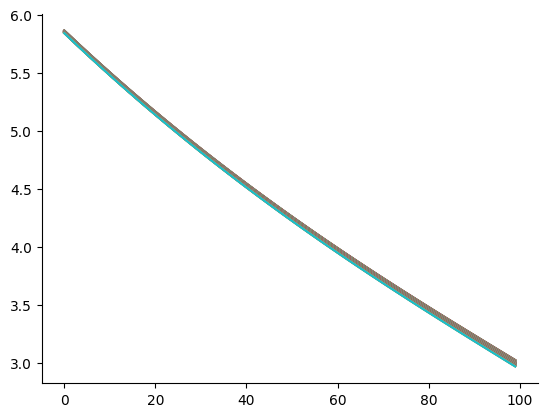

In [7]:
plt.plot(ϕ_list[0])
plt.show()

In [8]:
ems_list = np.array([solu[γ3]["ems"] for γ3 in γ3_list])
# np.save("ems_2state", ems_list)

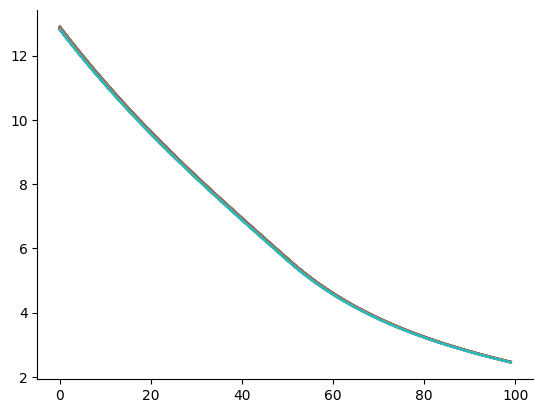

In [9]:
plt.plot(ems_list[1])
# plt.ylim(-6,6)
plt.show()

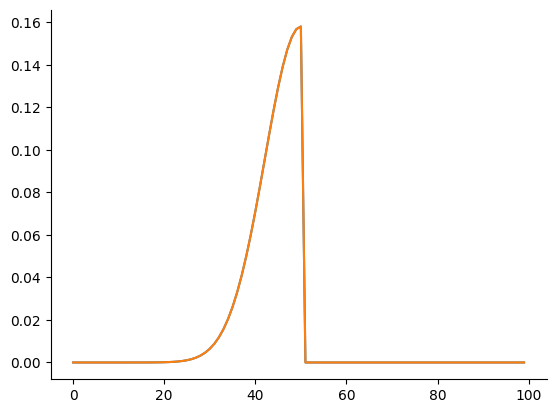

In [13]:
Intensity = 1 / 2*np.sqrt(0.1 )*np.exp( - (y1_grid - 2)**2 / 2 / 0.1) *(y1_grid <= 2) 
plt.plot(Intensity)
plt.show()

In [17]:
y1_grid_cap = np.arange(0., 2. + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.1
max_iter = 5000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = 1 / 2*np.sqrt(0.1 )*np.exp( - (y1_mat_cap - 2)**2 / 2 / 0.1) *(y1_mat_cap <= 2) 
# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][ :loc_2 + 1]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.02 + ems_old * 0.98
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.088228274090	 rhs error: 0.088130891164
Episode: 2	 lhs error: 0.068795039678	 rhs error: 0.068848345668
Episode: 3	 lhs error: 0.057493067383	 rhs error: 0.057564501148
Episode: 4	 lhs error: 0.049500151871	 rhs error: 0.049587748419
Episode: 5	 lhs error: 0.043788929664	 rhs error: 0.043577950953
Episode: 6	 lhs error: 0.038826659599	 rhs error: 0.039868825141
Episode: 7	 lhs error: 0.034979951076	 rhs error: 0.036187363471
Episode: 8	 lhs error: 0.031783492205	 rhs error: 0.032711712420
Episode: 9	 lhs error: 0.029029689709	 rhs error: 0.030502346128
Episode: 10	 lhs error: 0.027314821914	 rhs error: 0.028125182822
Episode: 11	 lhs error: 0.025909336272	 rhs error: 0.026260768985
Episode: 12	 lhs error: 0.024478919827	 rhs error: 0.025678333938
Episode: 13	 lhs error: 0.023155687330	 rhs error: 0.025316722000
Episode: 14	 lhs error: 0.022043663431	 rhs error: 0.025066988902
Episode: 15	 lhs error: 0.021561062660	 rhs error: 0.024669539597
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.170238438344	 rhs error: 22.639666939371
Episode: 126	 lhs error: 0.105465010257	 rhs error: 38.527063122217
Episode: 127	 lhs error: 0.080289190510	 rhs error: 31.007663740906
Episode: 128	 lhs error: 0.055595373234	 rhs error: 21.648672785068
Episode: 129	 lhs error: 0.047090683878	 rhs error: 15.754124487524
Episode: 130	 lhs error: 0.047456044525	 rhs error: 12.239291106752
Episode: 131	 lhs error: 0.030958625364	 rhs error: 10.241896724317
Episode: 132	 lhs error: 0.053623304353	 rhs error: 9.088180253811
Episode: 133	 lhs error: 0.034795632896	 rhs error: 8.426869642737
Episode: 134	 lhs error: 0.061162392622	 rhs error: 8.000183047705
Episode: 135	 lhs error: 0.038802270960	 rhs error: 7.682720521245
Episode: 136	 lhs error: 0.066689618385	 rhs error: 7.450641722225
Episode: 137	 lhs error: 0.043011449358	 rhs error: 7.279224119090
Episode: 138	 lhs error: 0.074802678358	 rhs error: 7.105046829906
Episode: 139	 lhs error: 0.038887457501	 rhs error: 6.9

Episode: 249	 lhs error: 0.022111708477	 rhs error: 0.605257483700
Episode: 250	 lhs error: 0.034414733444	 rhs error: 0.590455137470
Episode: 251	 lhs error: 0.051065508936	 rhs error: 0.575900782232
Episode: 252	 lhs error: 0.045235077244	 rhs error: 0.562402557917
Episode: 253	 lhs error: 0.027875417267	 rhs error: 0.550148483171
Episode: 254	 lhs error: 0.027927453846	 rhs error: 0.538264141223
Episode: 255	 lhs error: 0.029242262577	 rhs error: 0.523041911966
Episode: 256	 lhs error: 0.045538012406	 rhs error: 0.511603239927
Episode: 257	 lhs error: 0.033087441910	 rhs error: 0.500157013389
Episode: 258	 lhs error: 0.040092140592	 rhs error: 0.486053576586
Episode: 259	 lhs error: 0.033249090841	 rhs error: 0.477248827983
Episode: 260	 lhs error: 0.031480970206	 rhs error: 0.465803163290
Episode: 261	 lhs error: 0.050276349927	 rhs error: 0.457727150641
Episode: 262	 lhs error: 0.025969855610	 rhs error: 0.442707223112
Episode: 263	 lhs error: 0.074786042210	 rhs error: 0.43289195

Episode: 373	 lhs error: 0.002025880908	 rhs error: 0.028995730269
Episode: 374	 lhs error: 0.001989941106	 rhs error: 0.027961946450
Episode: 375	 lhs error: 0.001952821907	 rhs error: 0.026959441247
Episode: 376	 lhs error: 0.001914883156	 rhs error: 0.025988534976
Episode: 377	 lhs error: 0.001876753923	 rhs error: 0.025049183084
Episode: 378	 lhs error: 0.001839557256	 rhs error: 0.024189926851
Episode: 379	 lhs error: 0.001815443992	 rhs error: 0.023265576196
Episode: 380	 lhs error: 0.001810551677	 rhs error: 0.022414973980
Episode: 381	 lhs error: 0.001805113749	 rhs error: 0.021596249285
Episode: 382	 lhs error: 0.001797437197	 rhs error: 0.020806946240
Episode: 383	 lhs error: 0.001785994946	 rhs error: 0.020041777409
Episode: 384	 lhs error: 0.001769021203	 rhs error: 0.019307927326
Episode: 385	 lhs error: 0.001740426247	 rhs error: 0.018602543604
Episode: 386	 lhs error: 0.001662005342	 rhs error: 0.017929015785
Episode: 387	 lhs error: 0.001696382674	 rhs error: 0.01730699

Episode: 497	 lhs error: 0.000795099282	 rhs error: 0.015410822768
Episode: 498	 lhs error: 0.000852522647	 rhs error: 0.015337681291
Episode: 499	 lhs error: 0.000828262655	 rhs error: 0.015366185985
Episode: 500	 lhs error: 0.000846581063	 rhs error: 0.015346954249
Episode: 501	 lhs error: 0.000854486067	 rhs error: 0.015369899516
Episode: 502	 lhs error: 0.000843058783	 rhs error: 0.015374777133
Episode: 503	 lhs error: 0.000845481973	 rhs error: 0.015375577539
Episode: 504	 lhs error: 0.000850792960	 rhs error: 0.015379580502
Episode: 505	 lhs error: 0.000860315567	 rhs error: 0.015382257687
Episode: 506	 lhs error: 0.000873122749	 rhs error: 0.015386606697
Episode: 507	 lhs error: 0.000773169343	 rhs error: 0.015383296261
Episode: 508	 lhs error: 0.000794002600	 rhs error: 0.015404186807
Episode: 509	 lhs error: 0.000853308374	 rhs error: 0.015393537417
Episode: 510	 lhs error: 0.000767637999	 rhs error: 0.015405084228
Episode: 511	 lhs error: 0.000794884967	 rhs error: 0.01540789

Episode: 621	 lhs error: 0.000663386595	 rhs error: 0.015487181887
Episode: 622	 lhs error: 0.000651263935	 rhs error: 0.015501325057
Episode: 623	 lhs error: 0.000627162596	 rhs error: 0.015502994199
Episode: 624	 lhs error: 0.000626098470	 rhs error: 0.015506914867
Episode: 625	 lhs error: 0.000614206302	 rhs error: 0.015504166820
Episode: 626	 lhs error: 0.000666247431	 rhs error: 0.015506068876
Episode: 627	 lhs error: 0.000639712489	 rhs error: 0.015469165638
Episode: 628	 lhs error: 0.000629465676	 rhs error: 0.015483721227
Episode: 629	 lhs error: 0.000613090736	 rhs error: 0.015484743465
Episode: 630	 lhs error: 0.000611382715	 rhs error: 0.015486673173
Episode: 631	 lhs error: 0.000651187074	 rhs error: 0.015486603546
Episode: 632	 lhs error: 0.000625712887	 rhs error: 0.015454810025
Episode: 633	 lhs error: 0.000616554581	 rhs error: 0.015468234846
Episode: 634	 lhs error: 0.000643027715	 rhs error: 0.015471403342
Episode: 635	 lhs error: 0.000618901791	 rhs error: 0.01544687

Episode: 745	 lhs error: 0.000510045628	 rhs error: 0.015377583136
Episode: 746	 lhs error: 0.000623811104	 rhs error: 0.015374724895
Episode: 747	 lhs error: 0.000508381039	 rhs error: 0.015375205470
Episode: 748	 lhs error: 0.000506867472	 rhs error: 0.015370581824
Episode: 749	 lhs error: 0.000505835100	 rhs error: 0.015369031947
Episode: 750	 lhs error: 0.000505196912	 rhs error: 0.015367774455
Episode: 751	 lhs error: 0.000504865902	 rhs error: 0.015366476617
Episode: 752	 lhs error: 0.000504713651	 rhs error: 0.015365138642
Episode: 753	 lhs error: 0.000504735399	 rhs error: 0.015363783624
Episode: 754	 lhs error: 0.000505125653	 rhs error: 0.015362424217
Episode: 755	 lhs error: 0.000505618102	 rhs error: 0.015361072797
Episode: 756	 lhs error: 0.000506176067	 rhs error: 0.015359733176
Episode: 757	 lhs error: 0.000506834180	 rhs error: 0.015358413038
Episode: 758	 lhs error: 0.000507563059	 rhs error: 0.015357123224
Episode: 759	 lhs error: 0.000508407144	 rhs error: 0.01535586

Episode: 869	 lhs error: 0.000482113124	 rhs error: 0.015389722666
Episode: 870	 lhs error: 0.000484471085	 rhs error: 0.015388912952
Episode: 871	 lhs error: 0.000487053466	 rhs error: 0.015388134242
Episode: 872	 lhs error: 0.000489349017	 rhs error: 0.015387741170
Episode: 873	 lhs error: 0.000491012954	 rhs error: 0.015387660649
Episode: 874	 lhs error: 0.000492213905	 rhs error: 0.015387705657
Episode: 875	 lhs error: 0.000493278196	 rhs error: 0.015387749588
Episode: 876	 lhs error: 0.000494434415	 rhs error: 0.015387761702
Episode: 877	 lhs error: 0.000495617749	 rhs error: 0.015387782031
Episode: 878	 lhs error: 0.000496701765	 rhs error: 0.015387847523
Episode: 879	 lhs error: 0.000497675294	 rhs error: 0.015387973931
Episode: 880	 lhs error: 0.000498505878	 rhs error: 0.015388157037
Episode: 881	 lhs error: 0.000499219359	 rhs error: 0.015388395799
Episode: 882	 lhs error: 0.000500064477	 rhs error: 0.015388675496
Episode: 883	 lhs error: 0.000500862756	 rhs error: 0.01538899

Episode: 993	 lhs error: 0.000456772132	 rhs error: 0.015399248564
Episode: 994	 lhs error: 0.000452098756	 rhs error: 0.015397685651
Episode: 995	 lhs error: 0.000447746621	 rhs error: 0.015396366268
Episode: 996	 lhs error: 0.000447881309	 rhs error: 0.015395932277
Episode: 997	 lhs error: 0.000447952197	 rhs error: 0.015395465879
Episode: 998	 lhs error: 0.000447411029	 rhs error: 0.015395005134
Episode: 999	 lhs error: 0.000445423709	 rhs error: 0.015394262581
Episode: 1000	 lhs error: 0.000443337854	 rhs error: 0.015393462693
Episode: 1001	 lhs error: 0.000441556084	 rhs error: 0.015392700415
Episode: 1002	 lhs error: 0.000440685130	 rhs error: 0.015392095074
Episode: 1003	 lhs error: 0.000440049079	 rhs error: 0.015391642623
Episode: 1004	 lhs error: 0.000439365320	 rhs error: 0.015391258626
Episode: 1005	 lhs error: 0.000438532067	 rhs error: 0.015390904062
Episode: 1006	 lhs error: 0.000437642141	 rhs error: 0.015390589051
Episode: 1007	 lhs error: 0.000436846799	 rhs error: 0.

Episode: 1117	 lhs error: 0.000305169529	 rhs error: 0.015370722785
Episode: 1118	 lhs error: 0.000325870758	 rhs error: 0.015384756640
Episode: 1119	 lhs error: 0.000294324529	 rhs error: 0.015387469125
Episode: 1120	 lhs error: 0.000312235915	 rhs error: 0.015400995300
Episode: 1121	 lhs error: 0.000290067644	 rhs error: 0.015389467652
Episode: 1122	 lhs error: 0.000302516510	 rhs error: 0.015385831443
Episode: 1123	 lhs error: 0.000342120401	 rhs error: 0.015391673815
Episode: 1124	 lhs error: 0.000287037434	 rhs error: 0.015384968922
Episode: 1125	 lhs error: 0.000349485849	 rhs error: 0.015403813743
Episode: 1126	 lhs error: 0.000325121660	 rhs error: 0.015384158720
Episode: 1127	 lhs error: 0.000349760653	 rhs error: 0.015383532910
Episode: 1128	 lhs error: 0.000311712168	 rhs error: 0.015375668132
Episode: 1129	 lhs error: 0.000325526232	 rhs error: 0.015379820498
Episode: 1130	 lhs error: 0.000336022363	 rhs error: 0.015382623599
Episode: 1131	 lhs error: 0.000333682962	 rhs er

Episode: 1241	 lhs error: 0.000206029674	 rhs error: 0.015383933821
Episode: 1242	 lhs error: 0.000263274151	 rhs error: 0.015389217179
Episode: 1243	 lhs error: 0.000194850485	 rhs error: 0.015384175458
Episode: 1244	 lhs error: 0.000261691030	 rhs error: 0.015389484773
Episode: 1245	 lhs error: 0.000194315791	 rhs error: 0.015384160124
Episode: 1246	 lhs error: 0.000259363830	 rhs error: 0.015389401216
Episode: 1247	 lhs error: 0.000218652860	 rhs error: 0.015384063585
Episode: 1248	 lhs error: 0.000257537867	 rhs error: 0.015389226620
Episode: 1249	 lhs error: 0.000237253926	 rhs error: 0.015383881165
Episode: 1250	 lhs error: 0.000255229572	 rhs error: 0.015388933046
Episode: 1251	 lhs error: 0.000257145465	 rhs error: 0.015383534001
Episode: 1252	 lhs error: 0.000253152492	 rhs error: 0.015388453854
Episode: 1253	 lhs error: 0.000270859088	 rhs error: 0.015383132239
Episode: 1254	 lhs error: 0.000250781380	 rhs error: 0.015387940173
Episode: 1255	 lhs error: 0.000284360449	 rhs er

Episode: 1365	 lhs error: 0.000153431938	 rhs error: 0.016356726621
Episode: 1366	 lhs error: 0.000485301895	 rhs error: 0.015525766139
Episode: 1367	 lhs error: 0.000185138837	 rhs error: 0.015430052412
Episode: 1368	 lhs error: 0.000199252400	 rhs error: 0.015411092735
Episode: 1369	 lhs error: 0.000205967623	 rhs error: 0.015407312941
Episode: 1370	 lhs error: 0.000205894634	 rhs error: 0.015405668140
Episode: 1371	 lhs error: 0.000203880546	 rhs error: 0.015404487241
Episode: 1372	 lhs error: 0.000373470123	 rhs error: 0.015400213417
Episode: 1373	 lhs error: 0.000119320822	 rhs error: 0.015399839857
Episode: 1374	 lhs error: 0.000121172787	 rhs error: 0.015396006681
Episode: 1375	 lhs error: 0.000108446232	 rhs error: 0.015395472566
Episode: 1376	 lhs error: 0.000110135582	 rhs error: 0.015394062566
Episode: 1377	 lhs error: 0.000109529834	 rhs error: 0.015393038659
Episode: 1378	 lhs error: 0.000110628035	 rhs error: 0.015392023861
Episode: 1379	 lhs error: 0.000110974395	 rhs er

Episode: 1489	 lhs error: 0.000150486245	 rhs error: 0.015430600803
Episode: 1490	 lhs error: 0.000236323289	 rhs error: 0.015463116371
Episode: 1491	 lhs error: 0.000237732419	 rhs error: 0.015427030428
Episode: 1492	 lhs error: 0.000083906834	 rhs error: 0.015414504608
Episode: 1493	 lhs error: 0.000070643756	 rhs error: 0.015195262830
Episode: 1494	 lhs error: 0.000120685889	 rhs error: 0.015381120359
Episode: 1495	 lhs error: 0.000211407406	 rhs error: 0.015411406700
Episode: 1496	 lhs error: 0.000410073457	 rhs error: 0.015401832775
Episode: 1497	 lhs error: 0.000373928763	 rhs error: 0.015397679540
Episode: 1498	 lhs error: 0.000354436538	 rhs error: 0.017161005019
Episode: 1499	 lhs error: 0.000195985241	 rhs error: 0.015602531656
Episode: 1500	 lhs error: 0.000208359263	 rhs error: 0.015383059593
Episode: 1501	 lhs error: 0.000186089151	 rhs error: 0.015407625885
Episode: 1502	 lhs error: 0.000180815937	 rhs error: 0.015409095319
Episode: 1503	 lhs error: 0.000181244407	 rhs er

Episode: 1613	 lhs error: 0.000072894487	 rhs error: 0.015439443457
Episode: 1614	 lhs error: 0.000564643176	 rhs error: 0.015435995920
Episode: 1615	 lhs error: 0.000219103729	 rhs error: 0.015438509508
Episode: 1616	 lhs error: 0.000076155461	 rhs error: 0.015438682594
Episode: 1617	 lhs error: 0.000570249077	 rhs error: 0.015434353040
Episode: 1618	 lhs error: 0.000522650881	 rhs error: 0.015432506174
Episode: 1619	 lhs error: 0.000382974743	 rhs error: 0.015428478165
Episode: 1620	 lhs error: 0.000100344193	 rhs error: 0.015423939738
Episode: 1621	 lhs error: 0.000553735287	 rhs error: 0.015426561626
Episode: 1622	 lhs error: 0.000492311756	 rhs error: 0.015425056897
Episode: 1623	 lhs error: 0.000152761064	 rhs error: 0.015410883393
Episode: 1624	 lhs error: 0.000515995613	 rhs error: 0.015423101045
Episode: 1625	 lhs error: 0.000600349206	 rhs error: 0.015422822137
Episode: 1626	 lhs error: 0.000420725975	 rhs error: 0.015274116430
Episode: 1627	 lhs error: 0.000055300813	 rhs er

Episode: 1737	 lhs error: 0.000332724098	 rhs error: 0.015345166829
Episode: 1738	 lhs error: 0.000328184850	 rhs error: 0.015343844906
Episode: 1739	 lhs error: 0.000330590553	 rhs error: 0.015342523592
Episode: 1740	 lhs error: 0.000323591271	 rhs error: 0.015341230063
Episode: 1741	 lhs error: 0.000324721984	 rhs error: 0.015339919171
Episode: 1742	 lhs error: 0.000321008663	 rhs error: 0.015338677757
Episode: 1743	 lhs error: 0.000318944024	 rhs error: 0.015337396976
Episode: 1744	 lhs error: 0.000318356602	 rhs error: 0.015336181654
Episode: 1745	 lhs error: 0.000313809862	 rhs error: 0.015334947949
Episode: 1746	 lhs error: 0.000313257636	 rhs error: 0.015333722713
Episode: 1747	 lhs error: 0.000310805609	 rhs error: 0.015332549967
Episode: 1748	 lhs error: 0.000307489966	 rhs error: 0.015331370995
Episode: 1749	 lhs error: 0.000307469676	 rhs error: 0.015330225451
Episode: 1750	 lhs error: 0.000306118018	 rhs error: 0.015329068295
Episode: 1751	 lhs error: 0.000301700285	 rhs er

Episode: 1861	 lhs error: 0.000079634356	 rhs error: 0.015412502877
Episode: 1862	 lhs error: 0.000182245428	 rhs error: 0.015419744384
Episode: 1863	 lhs error: 0.000319735309	 rhs error: 0.015427319223
Episode: 1864	 lhs error: 0.000427236035	 rhs error: 0.015438824128
Episode: 1865	 lhs error: 0.000477017138	 rhs error: 0.015453968985
Episode: 1866	 lhs error: 0.000291866346	 rhs error: 0.015475803536
Episode: 1867	 lhs error: 0.000236820823	 rhs error: 0.015498232344
Episode: 1868	 lhs error: 0.000321807358	 rhs error: 0.015474830117
Episode: 1869	 lhs error: 0.000277933174	 rhs error: 0.015451880085
Episode: 1870	 lhs error: 0.000191764703	 rhs error: 0.015445833027
Episode: 1871	 lhs error: 0.000153742576	 rhs error: 0.015443567259
Episode: 1872	 lhs error: 0.000162937865	 rhs error: 0.015441847229
Episode: 1873	 lhs error: 0.000194288503	 rhs error: 0.015439917354
Episode: 1874	 lhs error: 0.000222111689	 rhs error: 0.015438073455
Episode: 1875	 lhs error: 0.000251621009	 rhs er

Episode: 1985	 lhs error: 0.000264892558	 rhs error: 0.015495905331
Episode: 1986	 lhs error: 0.000105880837	 rhs error: 0.015461064219
Episode: 1987	 lhs error: 0.000428341141	 rhs error: 0.015444727509
Episode: 1988	 lhs error: 0.000675632999	 rhs error: 0.015277786556
Episode: 1989	 lhs error: 0.000508152810	 rhs error: 0.018847823136
Episode: 1990	 lhs error: 0.000069870549	 rhs error: 0.015210785345
Episode: 1991	 lhs error: 0.000488017534	 rhs error: 0.015405572818
Episode: 1992	 lhs error: 0.000307016385	 rhs error: 0.015619987134
Episode: 1993	 lhs error: 0.000202152654	 rhs error: 0.015404447539
Episode: 1994	 lhs error: 0.000161751648	 rhs error: 0.015446034003
Episode: 1995	 lhs error: 0.000234693655	 rhs error: 0.015708752517
Episode: 1996	 lhs error: 0.000138444518	 rhs error: 0.015381543929
Episode: 1997	 lhs error: 0.000076519092	 rhs error: 0.015456460167
Episode: 1998	 lhs error: 0.000689855652	 rhs error: 0.015451762650
Episode: 1999	 lhs error: 0.000589355025	 rhs er

Episode: 2109	 lhs error: 0.000075435196	 rhs error: 0.015404023749
Episode: 2110	 lhs error: 0.000545185625	 rhs error: 0.015428607426
Episode: 2111	 lhs error: 0.000356900468	 rhs error: 0.015477227467
Episode: 2112	 lhs error: 0.000048061742	 rhs error: 0.015406857778
Episode: 2113	 lhs error: 0.000703914847	 rhs error: 0.015433811909
Episode: 2114	 lhs error: 0.000362292550	 rhs error: 0.015494782522
Episode: 2115	 lhs error: 0.000029112200	 rhs error: 0.015412567352
Episode: 2116	 lhs error: 0.000849747366	 rhs error: 0.015441361028
Episode: 2117	 lhs error: 0.000181143093	 rhs error: 0.015515577104
Episode: 2118	 lhs error: 0.000787760580	 rhs error: 0.015223719266
Episode: 2119	 lhs error: 0.000127024684	 rhs error: 0.015404252338
Episode: 2120	 lhs error: 0.000079065117	 rhs error: 0.015394623931
Episode: 2121	 lhs error: 0.000449856253	 rhs error: 0.015448949763
Episode: 2122	 lhs error: 0.000588479259	 rhs error: 0.015577814522
Episode: 2123	 lhs error: 0.000517730897	 rhs er

Episode: 2233	 lhs error: 0.000054433232	 rhs error: 0.015326069115
Episode: 2234	 lhs error: 0.000105553886	 rhs error: 0.015342265456
Episode: 2235	 lhs error: 0.000533763130	 rhs error: 0.015372129309
Episode: 2236	 lhs error: 0.000028728507	 rhs error: 0.015367149452
Episode: 2237	 lhs error: 0.000498636472	 rhs error: 0.015369769259
Episode: 2238	 lhs error: 0.000179469615	 rhs error: 0.015326867470
Episode: 2239	 lhs error: 0.000244138780	 rhs error: 0.015358751694
Episode: 2240	 lhs error: 0.000415111713	 rhs error: 0.015369515608
Episode: 2241	 lhs error: 0.000218171294	 rhs error: 0.015416471118
Episode: 2242	 lhs error: 0.000163691113	 rhs error: 0.015359494143
Episode: 2243	 lhs error: 0.000247252561	 rhs error: 0.015360257038
Episode: 2244	 lhs error: 0.000240434065	 rhs error: 0.015381700598
Episode: 2245	 lhs error: 0.000171394359	 rhs error: 0.015381855460
Episode: 2246	 lhs error: 0.000175893818	 rhs error: 0.015382550175
Episode: 2247	 lhs error: 0.000162931978	 rhs er

Episode: 2357	 lhs error: 0.000147401532	 rhs error: 0.015428988857
Episode: 2358	 lhs error: 0.000041210107	 rhs error: 0.015425603390
Episode: 2359	 lhs error: 0.000162425992	 rhs error: 0.015424410758
Episode: 2360	 lhs error: 0.000231308952	 rhs error: 0.015423606329
Episode: 2361	 lhs error: 0.000198100532	 rhs error: 0.015422757629
Episode: 2362	 lhs error: 0.000171965525	 rhs error: 0.015422515505
Episode: 2363	 lhs error: 0.000185765396	 rhs error: 0.015422748125
Episode: 2364	 lhs error: 0.000211376102	 rhs error: 0.015423032615
Episode: 2365	 lhs error: 0.000228284715	 rhs error: 0.015423336646
Episode: 2366	 lhs error: 0.000241416370	 rhs error: 0.015423835152
Episode: 2367	 lhs error: 0.000255591335	 rhs error: 0.015424537903
Episode: 2368	 lhs error: 0.000278385209	 rhs error: 0.015425498362
Episode: 2369	 lhs error: 0.000307743429	 rhs error: 0.015426699594
Episode: 2370	 lhs error: 0.000343337918	 rhs error: 0.015428211078
Episode: 2371	 lhs error: 0.000388739778	 rhs er

Episode: 2481	 lhs error: 0.000245973893	 rhs error: 0.015430073290
Episode: 2482	 lhs error: 0.000251074835	 rhs error: 0.015430951678
Episode: 2483	 lhs error: 0.000256110574	 rhs error: 0.015431951792
Episode: 2484	 lhs error: 0.000261027394	 rhs error: 0.015433045358
Episode: 2485	 lhs error: 0.000265976378	 rhs error: 0.015434232547
Episode: 2486	 lhs error: 0.000270783373	 rhs error: 0.015435488112
Episode: 2487	 lhs error: 0.000275580254	 rhs error: 0.015436819712
Episode: 2488	 lhs error: 0.000280242785	 rhs error: 0.015438201281
Episode: 2489	 lhs error: 0.000284761588	 rhs error: 0.015439632892
Episode: 2490	 lhs error: 0.000289055047	 rhs error: 0.015441109508
Episode: 2491	 lhs error: 0.000293268801	 rhs error: 0.015442630426
Episode: 2492	 lhs error: 0.000297264217	 rhs error: 0.015444179050
Episode: 2493	 lhs error: 0.000301102747	 rhs error: 0.015445764962
Episode: 2494	 lhs error: 0.000304671301	 rhs error: 0.015447372648
Episode: 2495	 lhs error: 0.000308064245	 rhs er

Episode: 2605	 lhs error: 0.000365609228	 rhs error: 0.015502869689
Episode: 2606	 lhs error: 0.000321618968	 rhs error: 0.015502563862
Episode: 2607	 lhs error: 0.000282554172	 rhs error: 0.015502860709
Episode: 2608	 lhs error: 0.000270796535	 rhs error: 0.015503381814
Episode: 2609	 lhs error: 0.000278813568	 rhs error: 0.015504203839
Episode: 2610	 lhs error: 0.000295071381	 rhs error: 0.015505152359
Episode: 2611	 lhs error: 0.000314025117	 rhs error: 0.015506257031
Episode: 2612	 lhs error: 0.000230412052	 rhs error: 0.015509448180
Episode: 2613	 lhs error: 0.000546811234	 rhs error: 0.016923794788
Episode: 2614	 lhs error: 0.000129363548	 rhs error: 0.015544464742
Episode: 2615	 lhs error: 0.000088131130	 rhs error: 0.015505414969
Episode: 2616	 lhs error: 0.000287437250	 rhs error: 0.015551127073
Episode: 2617	 lhs error: 0.000784312956	 rhs error: 0.015508480332
Episode: 2618	 lhs error: 0.000757225173	 rhs error: 0.015519676756
Episode: 2619	 lhs error: 0.000721346354	 rhs er

Episode: 2729	 lhs error: 0.000102285890	 rhs error: 0.015347618931
Episode: 2730	 lhs error: 0.000119836172	 rhs error: 0.015434252069
Episode: 2731	 lhs error: 0.000122546647	 rhs error: 0.015461516661
Episode: 2732	 lhs error: 0.000586065218	 rhs error: 0.015424835464
Episode: 2733	 lhs error: 0.000306129731	 rhs error: 0.015461755273
Episode: 2734	 lhs error: 0.000062569428	 rhs error: 0.015566392955
Episode: 2735	 lhs error: 0.000055639986	 rhs error: 0.015484850835
Episode: 2736	 lhs error: 0.000056314933	 rhs error: 0.015468454847
Episode: 2737	 lhs error: 0.000514212928	 rhs error: 0.015459119222
Episode: 2738	 lhs error: 0.000113129581	 rhs error: 0.015458667062
Episode: 2739	 lhs error: 0.000094709028	 rhs error: 0.015462592965
Episode: 2740	 lhs error: 0.000051687225	 rhs error: 0.015458342184
Episode: 2741	 lhs error: 0.000082583944	 rhs error: 0.015456919698
Episode: 2742	 lhs error: 0.000088413520	 rhs error: 0.015466255558
Episode: 2743	 lhs error: 0.000320416131	 rhs er

Episode: 2853	 lhs error: 0.000053985138	 rhs error: 0.015430932211
Episode: 2854	 lhs error: 0.000068231019	 rhs error: 0.015431186078
Episode: 2855	 lhs error: 0.000075551524	 rhs error: 0.015431353770
Episode: 2856	 lhs error: 0.000075843742	 rhs error: 0.015431608264
Episode: 2857	 lhs error: 0.000076529188	 rhs error: 0.015431874343
Episode: 2858	 lhs error: 0.000074956140	 rhs error: 0.015432144304
Episode: 2859	 lhs error: 0.000083947293	 rhs error: 0.015432432358
Episode: 2860	 lhs error: 0.000074118923	 rhs error: 0.015432718010
Episode: 2861	 lhs error: 0.000081206995	 rhs error: 0.015433124905
Episode: 2862	 lhs error: 0.000074149510	 rhs error: 0.015433309412
Episode: 2863	 lhs error: 0.000073294623	 rhs error: 0.015433691471
Episode: 2864	 lhs error: 0.000065181997	 rhs error: 0.015434007354
Episode: 2865	 lhs error: 0.000068552316	 rhs error: 0.015434396632
Episode: 2866	 lhs error: 0.000053344046	 rhs error: 0.015434530624
Episode: 2867	 lhs error: 0.000058384962	 rhs er

Episode: 2977	 lhs error: 0.000342182367	 rhs error: 0.015477813450
Episode: 2978	 lhs error: 0.000364648294	 rhs error: 0.015478408470
Episode: 2979	 lhs error: 0.000387526086	 rhs error: 0.015479135530
Episode: 2980	 lhs error: 0.000411027080	 rhs error: 0.015480053267
Episode: 2981	 lhs error: 0.000434071826	 rhs error: 0.015481167673
Episode: 2982	 lhs error: 0.000456945258	 rhs error: 0.015482460463
Episode: 2983	 lhs error: 0.000480625503	 rhs error: 0.015483915858
Episode: 2984	 lhs error: 0.000505040658	 rhs error: 0.015485563365
Episode: 2985	 lhs error: 0.000530496179	 rhs error: 0.015487431074
Episode: 2986	 lhs error: 0.000557564879	 rhs error: 0.015489521318
Episode: 2987	 lhs error: 0.000474105945	 rhs error: 0.015485657633
Episode: 2988	 lhs error: 0.000104653648	 rhs error: 0.015399282116
Episode: 2989	 lhs error: 0.000143973458	 rhs error: 0.015367453586
Episode: 2990	 lhs error: 0.000592555430	 rhs error: 0.015455327628
Episode: 2991	 lhs error: 0.000548651535	 rhs er

Episode: 3101	 lhs error: 0.000341243608	 rhs error: 0.015311288808
Episode: 3102	 lhs error: 0.000307635583	 rhs error: 0.015449464220
Episode: 3103	 lhs error: 0.000353664694	 rhs error: 0.015945619514
Episode: 3104	 lhs error: 0.000686109531	 rhs error: 0.015526981747
Episode: 3105	 lhs error: 0.000168660310	 rhs error: 0.015818087017
Episode: 3106	 lhs error: 0.000354248051	 rhs error: 0.015563918216
Episode: 3107	 lhs error: 0.000073359479	 rhs error: 0.015441529487
Episode: 3108	 lhs error: 0.000341165543	 rhs error: 0.015492972003
Episode: 3109	 lhs error: 0.000351607171	 rhs error: 0.015501630328
Episode: 3110	 lhs error: 0.000662386827	 rhs error: 0.015480146694
Episode: 3111	 lhs error: 0.000111968940	 rhs error: 0.015473286066
Episode: 3112	 lhs error: 0.000610511676	 rhs error: 0.015489749400
Episode: 3113	 lhs error: 0.000044769269	 rhs error: 0.015467321957
Episode: 3114	 lhs error: 0.000084452154	 rhs error: 0.015483039881
Episode: 3115	 lhs error: 0.000099436444	 rhs er

Episode: 3225	 lhs error: 0.000621300796	 rhs error: 0.015440794982
Episode: 3226	 lhs error: 0.000048919262	 rhs error: 0.015436490404
Episode: 3227	 lhs error: 0.000305645074	 rhs error: 0.015421527040
Episode: 3228	 lhs error: 0.000443671853	 rhs error: 0.015444649541
Episode: 3229	 lhs error: 0.000396625937	 rhs error: 0.015439886315
Episode: 3230	 lhs error: 0.000440402902	 rhs error: 0.015434908587
Episode: 3231	 lhs error: 0.000348161903	 rhs error: 0.015434504860
Episode: 3232	 lhs error: 0.000289453480	 rhs error: 0.015426818401
Episode: 3233	 lhs error: 0.000386891536	 rhs error: 0.015432754576
Episode: 3234	 lhs error: 0.000376668262	 rhs error: 0.015433568663
Episode: 3235	 lhs error: 0.000118352714	 rhs error: 0.015418685634
Episode: 3236	 lhs error: 0.000292361378	 rhs error: 0.015432312502
Episode: 3237	 lhs error: 0.000253986228	 rhs error: 0.015430376281
Episode: 3238	 lhs error: 0.000199861520	 rhs error: 0.015429980333
Episode: 3239	 lhs error: 0.000191871703	 rhs er

Episode: 3349	 lhs error: 0.000054998033	 rhs error: 0.015430823522
Episode: 3350	 lhs error: 0.000036238626	 rhs error: 0.015427446346
Episode: 3351	 lhs error: 0.000032948955	 rhs error: 0.015427505565
Episode: 3352	 lhs error: 0.000032269714	 rhs error: 0.015427583456
Episode: 3353	 lhs error: 0.000033058122	 rhs error: 0.015427554338
Episode: 3354	 lhs error: 0.000033725738	 rhs error: 0.015427541114
Episode: 3355	 lhs error: 0.000033697620	 rhs error: 0.015427566806
Episode: 3356	 lhs error: 0.000033263751	 rhs error: 0.015427607620
Episode: 3357	 lhs error: 0.000032887791	 rhs error: 0.015427662583
Episode: 3358	 lhs error: 0.000032621378	 rhs error: 0.015427708680
Episode: 3359	 lhs error: 0.000032499848	 rhs error: 0.015427762614
Episode: 3360	 lhs error: 0.000032477929	 rhs error: 0.015427818282
Episode: 3361	 lhs error: 0.000032505951	 rhs error: 0.015427873878
Episode: 3362	 lhs error: 0.000032605833	 rhs error: 0.015427931298
Episode: 3363	 lhs error: 0.000032738697	 rhs er

Episode: 3473	 lhs error: 0.000039083846	 rhs error: 0.015428937535
Episode: 3474	 lhs error: 0.000171099765	 rhs error: 0.015490690359
Episode: 3475	 lhs error: 0.000168372672	 rhs error: 0.015429091559
Episode: 3476	 lhs error: 0.000071660596	 rhs error: 0.015445666619
Episode: 3477	 lhs error: 0.000480799340	 rhs error: 0.015432398958
Episode: 3478	 lhs error: 0.000092334715	 rhs error: 0.015428668448
Episode: 3479	 lhs error: 0.000086413785	 rhs error: 0.015427234169
Episode: 3480	 lhs error: 0.000059065945	 rhs error: 0.015425987362
Episode: 3481	 lhs error: 0.000072908799	 rhs error: 0.015425258117
Episode: 3482	 lhs error: 0.000101424314	 rhs error: 0.015425256672
Episode: 3483	 lhs error: 0.000100701765	 rhs error: 0.015425173281
Episode: 3484	 lhs error: 0.000104065687	 rhs error: 0.015424580153
Episode: 3485	 lhs error: 0.000115664925	 rhs error: 0.015423780131
Episode: 3486	 lhs error: 0.000128192299	 rhs error: 0.015423010165
Episode: 3487	 lhs error: 0.000136529062	 rhs er

Episode: 3597	 lhs error: 0.000344637747	 rhs error: 0.015363471815
Episode: 3598	 lhs error: 0.000590765901	 rhs error: 0.015368316350
Episode: 3599	 lhs error: 0.000354595346	 rhs error: 0.015365001099
Episode: 3600	 lhs error: 0.000603513242	 rhs error: 0.015369868508
Episode: 3601	 lhs error: 0.000364480868	 rhs error: 0.015366527403
Episode: 3602	 lhs error: 0.000615840783	 rhs error: 0.015371417323
Episode: 3603	 lhs error: 0.000375275753	 rhs error: 0.015368041100
Episode: 3604	 lhs error: 0.000627175187	 rhs error: 0.015372939494
Episode: 3605	 lhs error: 0.000340329809	 rhs error: 0.015373755702
Episode: 3606	 lhs error: 0.000349345990	 rhs error: 0.015373556357
Episode: 3607	 lhs error: 0.000406959419	 rhs error: 0.015374974602
Episode: 3608	 lhs error: 0.000453261174	 rhs error: 0.015377084358
Episode: 3609	 lhs error: 0.000449902735	 rhs error: 0.015379287030
Episode: 3610	 lhs error: 0.000444738005	 rhs error: 0.015381367983
Episode: 3611	 lhs error: 0.000448928114	 rhs er

Episode: 3721	 lhs error: 0.000300931954	 rhs error: 0.015510181391
Episode: 3722	 lhs error: 0.000556107095	 rhs error: 0.015630262416
Episode: 3723	 lhs error: 0.000333429858	 rhs error: 0.015457981127
Episode: 3724	 lhs error: 0.000559624166	 rhs error: 0.015461475262
Episode: 3725	 lhs error: 0.000251429964	 rhs error: 0.015475783405
Episode: 3726	 lhs error: 0.000260802227	 rhs error: 0.015469519413
Episode: 3727	 lhs error: 0.000791564423	 rhs error: 0.015453030784
Episode: 3728	 lhs error: 0.000339815517	 rhs error: 0.015521537148
Episode: 3729	 lhs error: 0.000135642290	 rhs error: 0.015462324450
Episode: 3730	 lhs error: 0.000261802614	 rhs error: 0.015461152098
Episode: 3731	 lhs error: 0.000192692591	 rhs error: 0.015441096372
Episode: 3732	 lhs error: 0.000355810816	 rhs error: 0.015449983311
Episode: 3733	 lhs error: 0.000134274231	 rhs error: 0.015441079283
Episode: 3734	 lhs error: 0.000417935155	 rhs error: 0.015448517155
Episode: 3735	 lhs error: 0.000166708907	 rhs er

Episode: 3845	 lhs error: 0.000703440372	 rhs error: 0.015471244412
Episode: 3846	 lhs error: 0.000185666349	 rhs error: 0.015664903060
Episode: 3847	 lhs error: 0.000068442146	 rhs error: 0.015583737672
Episode: 3848	 lhs error: 0.000462939398	 rhs error: 0.015459744810
Episode: 3849	 lhs error: 0.000113375035	 rhs error: 0.015458893376
Episode: 3850	 lhs error: 0.000120952097	 rhs error: 0.015171933024
Episode: 3851	 lhs error: 0.000245635175	 rhs error: 0.015432765176
Episode: 3852	 lhs error: 0.000185127747	 rhs error: 0.015558748579
Episode: 3853	 lhs error: 0.000379029324	 rhs error: 0.015491718892
Episode: 3854	 lhs error: 0.000332857055	 rhs error: 0.015474059167
Episode: 3855	 lhs error: 0.000149803692	 rhs error: 0.015474654115
Episode: 3856	 lhs error: 0.000413596786	 rhs error: 0.015494483979
Episode: 3857	 lhs error: 0.000680740911	 rhs error: 0.015500379136
Episode: 3858	 lhs error: 0.000387147868	 rhs error: 0.015480681622
Episode: 3859	 lhs error: 0.000165772570	 rhs er

Episode: 3969	 lhs error: 0.000397243143	 rhs error: 0.015404846591
Episode: 3970	 lhs error: 0.000351729936	 rhs error: 0.015407033900
Episode: 3971	 lhs error: 0.000362776610	 rhs error: 0.015403254442
Episode: 3972	 lhs error: 0.000375955228	 rhs error: 0.015399254792
Episode: 3973	 lhs error: 0.000369010473	 rhs error: 0.015397628437
Episode: 3974	 lhs error: 0.000354309420	 rhs error: 0.015396878023
Episode: 3975	 lhs error: 0.000346092088	 rhs error: 0.015395668332
Episode: 3976	 lhs error: 0.000340843385	 rhs error: 0.015394290399
Episode: 3977	 lhs error: 0.000333673033	 rhs error: 0.015392936446
Episode: 3978	 lhs error: 0.000325968624	 rhs error: 0.015391612134
Episode: 3979	 lhs error: 0.000318564423	 rhs error: 0.015390346837
Episode: 3980	 lhs error: 0.000311769362	 rhs error: 0.015389105788
Episode: 3981	 lhs error: 0.000304766176	 rhs error: 0.015387881477
Episode: 3982	 lhs error: 0.000298069023	 rhs error: 0.015386597745
Episode: 3983	 lhs error: 0.000291254175	 rhs er

Episode: 4093	 lhs error: 0.000186443303	 rhs error: 0.015370204552
Episode: 4094	 lhs error: 0.000185324055	 rhs error: 0.015369410814
Episode: 4095	 lhs error: 0.000183820382	 rhs error: 0.015368628202
Episode: 4096	 lhs error: 0.000182475975	 rhs error: 0.015367850792
Episode: 4097	 lhs error: 0.000181103742	 rhs error: 0.015367085674
Episode: 4098	 lhs error: 0.000179709132	 rhs error: 0.015366331444
Episode: 4099	 lhs error: 0.000178245907	 rhs error: 0.015365590785
Episode: 4100	 lhs error: 0.000176851878	 rhs error: 0.015364860698
Episode: 4101	 lhs error: 0.000175293293	 rhs error: 0.015364143440
Episode: 4102	 lhs error: 0.000173628882	 rhs error: 0.015363434953
Episode: 4103	 lhs error: 0.000172218761	 rhs error: 0.015362736765
Episode: 4104	 lhs error: 0.000170620365	 rhs error: 0.015362055988
Episode: 4105	 lhs error: 0.000168918213	 rhs error: 0.015361386431
Episode: 4106	 lhs error: 0.000167512451	 rhs error: 0.015360725994
Episode: 4107	 lhs error: 0.000166034879	 rhs er

Episode: 4217	 lhs error: 0.000283474038	 rhs error: 0.015408806361
Episode: 4218	 lhs error: 0.000279496798	 rhs error: 0.015410522053
Episode: 4219	 lhs error: 0.000275477582	 rhs error: 0.015412218082
Episode: 4220	 lhs error: 0.000271428464	 rhs error: 0.015413907662
Episode: 4221	 lhs error: 0.000267274726	 rhs error: 0.015415588235
Episode: 4222	 lhs error: 0.000263018456	 rhs error: 0.015417274985
Episode: 4223	 lhs error: 0.000259106156	 rhs error: 0.015418973150
Episode: 4224	 lhs error: 0.000255341973	 rhs error: 0.015420694486
Episode: 4225	 lhs error: 0.000252185022	 rhs error: 0.015422459232
Episode: 4226	 lhs error: 0.000249354635	 rhs error: 0.015424302369
Episode: 4227	 lhs error: 0.000247615172	 rhs error: 0.015426279868
Episode: 4228	 lhs error: 0.000247509822	 rhs error: 0.015428465545
Episode: 4229	 lhs error: 0.000250642474	 rhs error: 0.015431019760
Episode: 4230	 lhs error: 0.000260687660	 rhs error: 0.015434282216
Episode: 4231	 lhs error: 0.000294500048	 rhs er

Episode: 4341	 lhs error: 0.000259465666	 rhs error: 0.015304753825
Episode: 4342	 lhs error: 0.000415476064	 rhs error: 0.015376389856
Episode: 4343	 lhs error: 0.000307961877	 rhs error: 0.015407290363
Episode: 4344	 lhs error: 0.000285076122	 rhs error: 0.015397906428
Episode: 4345	 lhs error: 0.000090556016	 rhs error: 0.015415622858
Episode: 4346	 lhs error: 0.000352423528	 rhs error: 0.015399656280
Episode: 4347	 lhs error: 0.000457284405	 rhs error: 0.015393164374
Episode: 4348	 lhs error: 0.000406525064	 rhs error: 0.015391614847
Episode: 4349	 lhs error: 0.000393835807	 rhs error: 0.015387981539
Episode: 4350	 lhs error: 0.000387792284	 rhs error: 0.015385160798
Episode: 4351	 lhs error: 0.000372062911	 rhs error: 0.015382763103
Episode: 4352	 lhs error: 0.000360073266	 rhs error: 0.015380306956
Episode: 4353	 lhs error: 0.000350640149	 rhs error: 0.015377956960
Episode: 4354	 lhs error: 0.000340169379	 rhs error: 0.015375761440
Episode: 4355	 lhs error: 0.000328955045	 rhs er

Episode: 4465	 lhs error: 0.000035941665	 rhs error: 0.015373010117
Episode: 4466	 lhs error: 0.000036242044	 rhs error: 0.015372999557
Episode: 4467	 lhs error: 0.000036556325	 rhs error: 0.015373013338
Episode: 4468	 lhs error: 0.000036860090	 rhs error: 0.015373030428
Episode: 4469	 lhs error: 0.000037158983	 rhs error: 0.015373056532
Episode: 4470	 lhs error: 0.000037463909	 rhs error: 0.015373102681
Episode: 4471	 lhs error: 0.000037766195	 rhs error: 0.015373153240
Episode: 4472	 lhs error: 0.000038054261	 rhs error: 0.015373210886
Episode: 4473	 lhs error: 0.000038339459	 rhs error: 0.015373296119
Episode: 4474	 lhs error: 0.000038618299	 rhs error: 0.015373385082
Episode: 4475	 lhs error: 0.000038890118	 rhs error: 0.015373487324
Episode: 4476	 lhs error: 0.000039212454	 rhs error: 0.015373608003
Episode: 4477	 lhs error: 0.000039548472	 rhs error: 0.015373739781
Episode: 4478	 lhs error: 0.000039881467	 rhs error: 0.015373872090
Episode: 4479	 lhs error: 0.000040205336	 rhs er

Episode: 4589	 lhs error: 0.000256725553	 rhs error: 0.015436382967
Episode: 4590	 lhs error: 0.000410759087	 rhs error: 0.015453926680
Episode: 4591	 lhs error: 0.000566510548	 rhs error: 0.015443680277
Episode: 4592	 lhs error: 0.000247376935	 rhs error: 0.015456831535
Episode: 4593	 lhs error: 0.000222004925	 rhs error: 0.015442601220
Episode: 4594	 lhs error: 0.000515130002	 rhs error: 0.015445652125
Episode: 4595	 lhs error: 0.000580166894	 rhs error: 0.015445639208
Episode: 4596	 lhs error: 0.000595371135	 rhs error: 0.015456968542
Episode: 4597	 lhs error: 0.000166880911	 rhs error: 0.015453254551
Episode: 4598	 lhs error: 0.000413672002	 rhs error: 0.015463336405
Episode: 4599	 lhs error: 0.000368439810	 rhs error: 0.015452992553
Episode: 4600	 lhs error: 0.000194405836	 rhs error: 0.015460333360
Episode: 4601	 lhs error: 0.000216669918	 rhs error: 0.015454276302
Episode: 4602	 lhs error: 0.000287644794	 rhs error: 0.015455602507
Episode: 4603	 lhs error: 0.000561010491	 rhs er

Episode: 4713	 lhs error: 0.000345707873	 rhs error: 0.015454359203
Episode: 4714	 lhs error: 0.000075614546	 rhs error: 0.015468753596
Episode: 4715	 lhs error: 0.000428791534	 rhs error: 0.015355554177
Episode: 4716	 lhs error: 0.000366935362	 rhs error: 0.015427064550
Episode: 4717	 lhs error: 0.000085028042	 rhs error: 0.015454731291
Episode: 4718	 lhs error: 0.000130218181	 rhs error: 0.015472855032
Episode: 4719	 lhs error: 0.000292398968	 rhs error: 0.015387350674
Episode: 4720	 lhs error: 0.000146439485	 rhs error: 0.015425700162
Episode: 4721	 lhs error: 0.000405299847	 rhs error: 0.015458525480
Episode: 4722	 lhs error: 0.000137448731	 rhs error: 0.015410977088
Episode: 4723	 lhs error: 0.000491050892	 rhs error: 0.015549806018
Episode: 4724	 lhs error: 0.000205672202	 rhs error: 0.015471745754
Episode: 4725	 lhs error: 0.000500437065	 rhs error: 0.015504666205
Episode: 4726	 lhs error: 0.000564874005	 rhs error: 0.015425867658
Episode: 4727	 lhs error: 0.000243819365	 rhs er

Episode: 4837	 lhs error: 0.000403686074	 rhs error: 0.015381775462
Episode: 4838	 lhs error: 0.000197430227	 rhs error: 0.015387381265
Episode: 4839	 lhs error: 0.000117181226	 rhs error: 0.015383834087
Episode: 4840	 lhs error: 0.000339264676	 rhs error: 0.015462042120
Episode: 4841	 lhs error: 0.000273206232	 rhs error: 0.015389743652
Episode: 4842	 lhs error: 0.000091978510	 rhs error: 0.015385504662
Episode: 4843	 lhs error: 0.000108096199	 rhs error: 0.015384587240
Episode: 4844	 lhs error: 0.000200375279	 rhs error: 0.015384411823
Episode: 4845	 lhs error: 0.000045545916	 rhs error: 0.015383366434
Episode: 4846	 lhs error: 0.000196966082	 rhs error: 0.015384361835
Episode: 4847	 lhs error: 0.000078567551	 rhs error: 0.015384006877
Episode: 4848	 lhs error: 0.000194570410	 rhs error: 0.015385092112
Episode: 4849	 lhs error: 0.000385204743	 rhs error: 0.015382894110
Episode: 4850	 lhs error: 0.000286158116	 rhs error: 0.015438665491
Episode: 4851	 lhs error: 0.000419936015	 rhs er

Episode: 4961	 lhs error: 0.000305365283	 rhs error: 0.015437464761
Episode: 4962	 lhs error: 0.000401406154	 rhs error: 0.015440317124
Episode: 4963	 lhs error: 0.000561772312	 rhs error: 0.015443868959
Episode: 4964	 lhs error: 0.000426177724	 rhs error: 0.015446801333
Episode: 4965	 lhs error: 0.000408281655	 rhs error: 0.015467029278
Episode: 4966	 lhs error: 0.000608119899	 rhs error: 0.015431322856
Episode: 4967	 lhs error: 0.000192296013	 rhs error: 0.015441378011
Episode: 4968	 lhs error: 0.000435964697	 rhs error: 0.015451795090
Episode: 4969	 lhs error: 0.000673619733	 rhs error: 0.015459008900
Episode: 4970	 lhs error: 0.000273671715	 rhs error: 0.015463843829
Episode: 4971	 lhs error: 0.000514739467	 rhs error: 0.015455936309
Episode: 4972	 lhs error: 0.000508036732	 rhs error: 0.015460614056
Episode: 4973	 lhs error: 0.000573886040	 rhs error: 0.015486797993
Episode: 4974	 lhs error: 0.000407722477	 rhs error: 0.015462188405
Episode: 4975	 lhs error: 0.000479631726	 rhs er

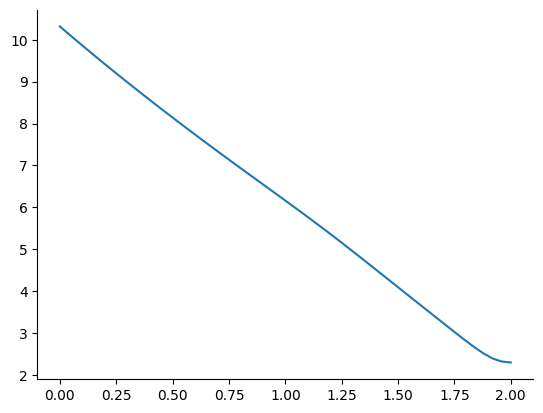

In [18]:
plt.plot(y1_grid_cap, ems[:,-1])
plt.show()

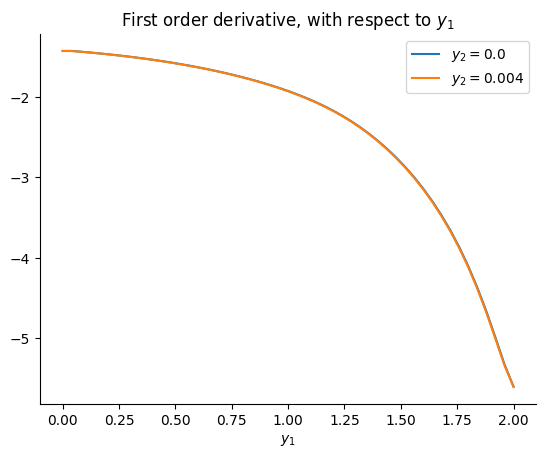

In [19]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

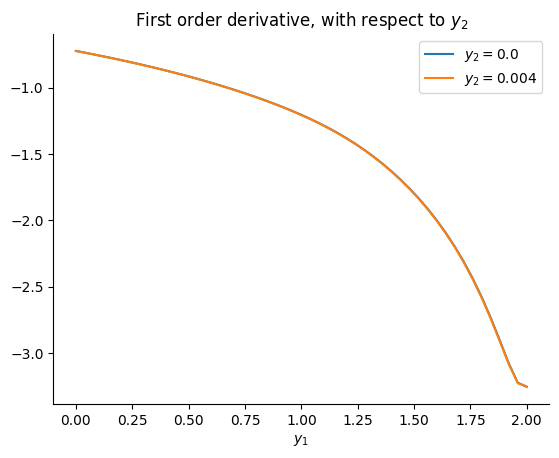

In [20]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

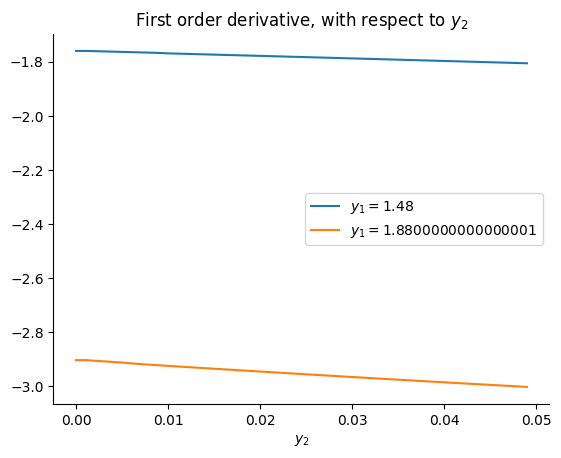

In [21]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

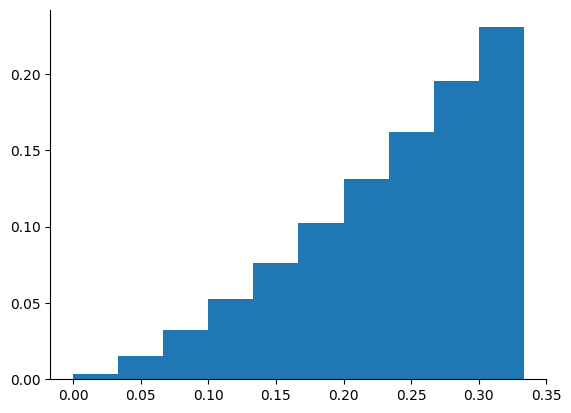

In [22]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

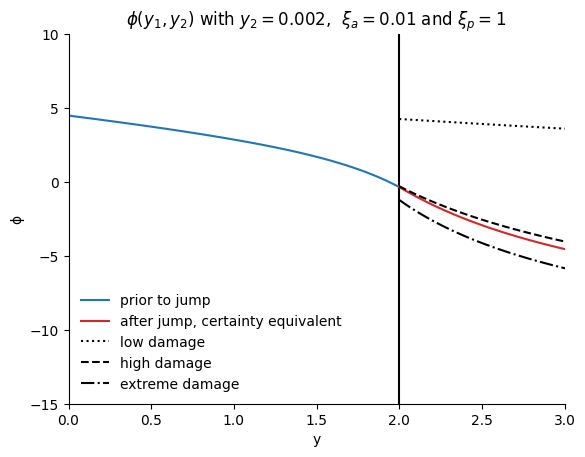

In [23]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

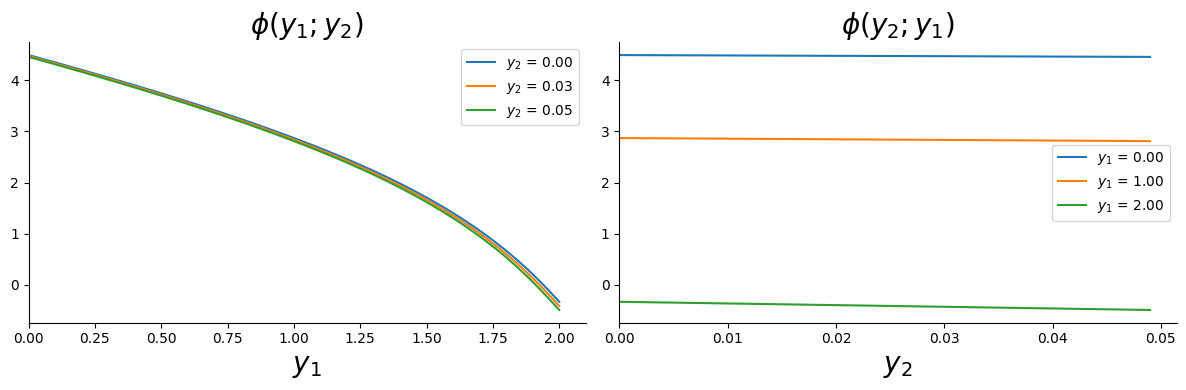

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

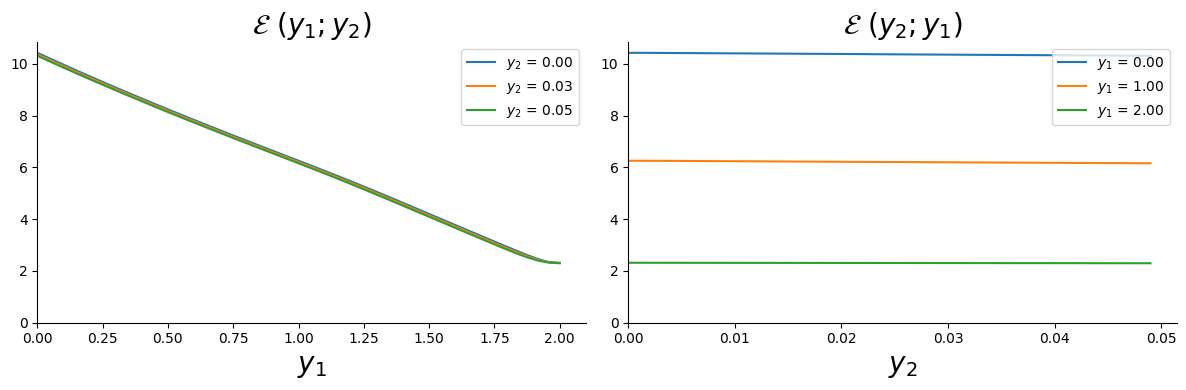

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

# Simulation

$$
Y_{n + 1}^1 = Y_{n}^1 + Y_{n}^2 \cdot \Delta t
$$

$$
Y_{n + 1}^2 =  (1 - \lambda \cdot \Delta t)  Y_{n}^2 + \lambda \cdot \theta \cdot \mathcal{E}(Y_n^1, Y_{n}^2) \cdot \Delta t
$$

In [40]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [51]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 =  np.exp(- λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i]
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [52]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [53]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [64]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

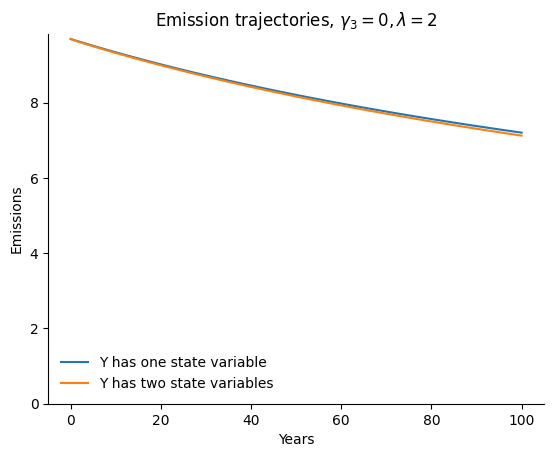

In [65]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_2")
plt.show()

In [73]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=100
                                                 )

In [74]:
ems_1d_pre = np.load("ems_1state_prejump.npy")
et_pre, yt_pre = simulation_1d(np.arange(0, 2 + 0.01, 0.01),
                               ems_1d_pre, θ=np.mean(θ_list), y_0=1.1
                                                 )

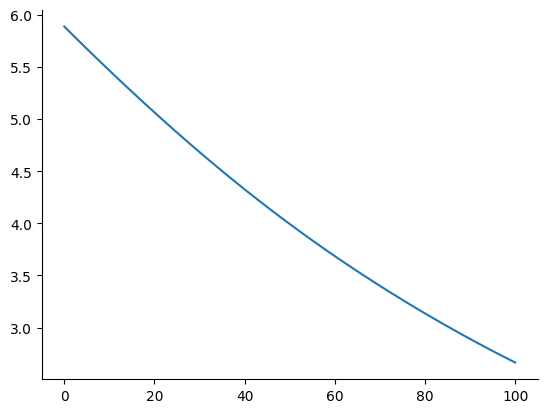

In [75]:
plt.plot(et_pre)
plt.show()

In [76]:
ems.max(), ems.min()

(10.430569625063637, 2.2991004616849415)

In [77]:
y1t_prejump

array([1.1       , 1.10969672, 1.1203659 , 1.13109527, 1.14176337,
       1.15235455, 1.16286726, 1.17330157, 1.18365738, 1.19393521,
       1.20413563, 1.21425893, 1.22430522, 1.234275  , 1.24416886,
       1.25398703, 1.26372959, 1.27339705, 1.28298999, 1.29250877,
       1.30195345, 1.31132456, 1.32062265, 1.32984828, 1.33900159,
       1.34808307, 1.35709328, 1.36603279, 1.37490185, 1.38370084,
       1.39243031, 1.4010908 , 1.40968283, 1.41820675, 1.42666309,
       1.43505238, 1.44337515, 1.45163193, 1.45982322, 1.46794953,
       1.47601138, 1.48400927, 1.49194367, 1.49981502, 1.50762382,
       1.51537058, 1.52305579, 1.53067997, 1.53824367, 1.54574737,
       1.55319155, 1.56057668, 1.56790324, 1.5751718 , 1.5823828 ,
       1.58953672, 1.596634  , 1.60367507, 1.61066037, 1.6175903 ,
       1.62446531, 1.63128583, 1.63805229, 1.64476514, 1.65142484,
       1.65803187, 1.66458664, 1.67108956, 1.67754105, 1.6839415 ,
       1.69029135, 1.696591  , 1.70284085, 1.70904129, 1.71519

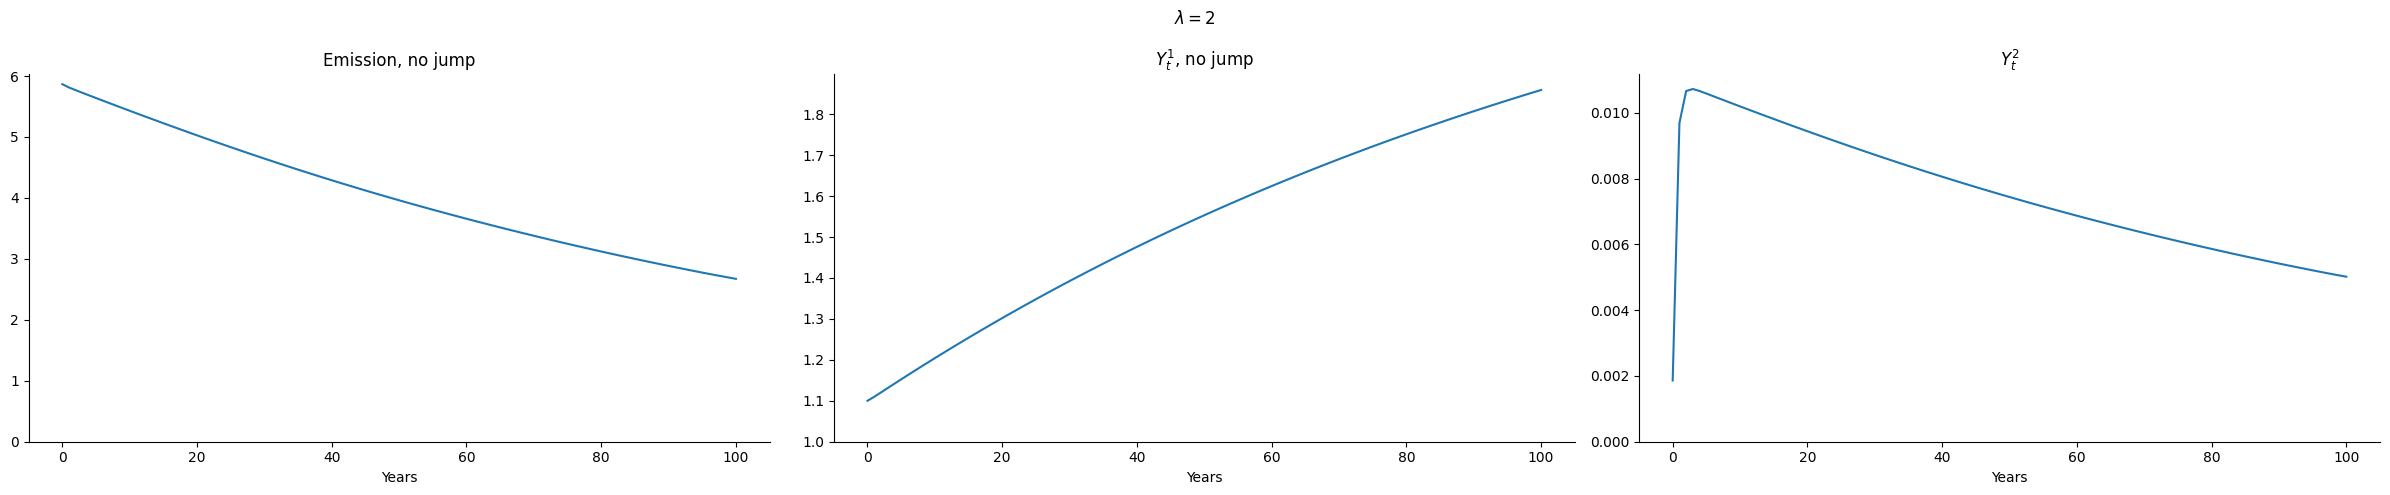

In [89]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_old_{λ}")
plt.show()

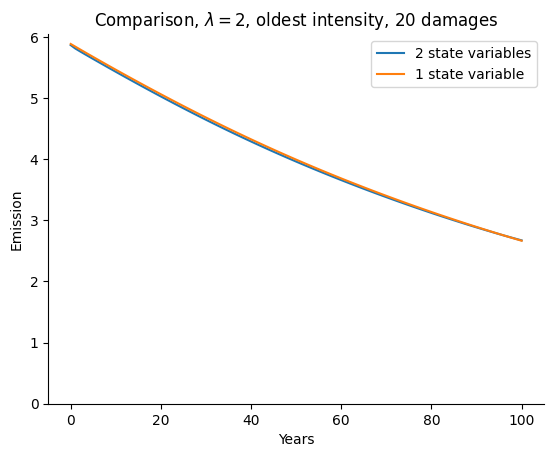

In [93]:
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_pre, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$, oldest intensity, 20 damages')
# plt.savefig("emissions_2_old")
plt.show()

In [90]:
np.save("et_1state_old", et_pre)

In [86]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [ ]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [ ]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, dt=1/4)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/Et*1000

In [ ]:
plt.plot(years, scc)

In [168]:
# ξₘ is 1000, no ambiguity over damage
numy_bar = 50
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)
ς = 0.1
ξa = 1/100
ξw = 1000
ξp = 5
σy = 1e-5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_1, et_1 = simulate_ems_1d(y_grid[:numy_bar+1], solu["ems"], dt=1/4)

episode: 5000,	 ode error: 9.905671455526233e-05,	 ft error: 3.316203585068678e-05
episode: 5000,	 ode error: 0.0004189112227439215,	 ft error: 2.3994517419301253e-05
episode: 812,	 ode error: 0.0020503496427756313,	 ft error: 9.875385842406104e-09
episode: 5000,	 ode error: 0.0015449065580850421,	 ft error: 1.7729717254388877e-05


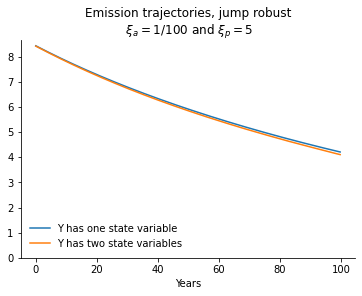

In [402]:
plt.plot(years, et_1, label="Y has one state variable")
plt.plot(years, Et_jump, label="Y has two state variables")
plt.ylim(0)
plt.xlabel("Years")
plt.title("Emission trajectories, jump robust\n $ξ_a = 1/100$ and $ξ_p = 5$")
plt.legend(frameon=False, loc=3)
# plt.savefig("./paper_plots/ems_12compare.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")

In [167]:
def simulate_ems_1d(y1_grid, ems_1d, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
#     Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp1d(y1_grid, ems_1d,)
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y1)
        ems_t[t] = ems_point
        Y1t[t] = y1
#         Y2t[t] = y2
        y1 += ems_point*θ*dt
#         y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, ems_t

In [ ]:
y1_1d, et_1d = simualte_ems_1d(y1_grid, ems_1d, dt=1/4)

In [ ]:
plt.plot(years, et_1d)
plt.plot(years, Et)
plt.xlim(0)
plt.ylim(0, 20)

In [ ]:
scc_1d =  η*(α - invkap)*np.exp(Kt)/(1-η)/et_1d*1000
plt.plot(years, scc_1d, label="pde")
plt.plot(years, scc, label="ode")
plt.legend()